# Style Transfer, Yolo, Embeddings - Aly Khater, Justin Sun

In this lab, you will work on the following concepts.

- Style transfer
- Yolo
- Embeddings

In [1]:
# portions of this lab were taken from Deep Learning with Python

import glob
import os
import random
import shutil

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import numpy as np
from random import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
!pip install umap-learn
import umap

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

C:\Users\Owner\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Neural Style Transfer

Execute the neural style transfer algorithm on an Santa Clara University image to generate a GIF of the different generations of the picture.

https://keras.io/examples/generative/neural_style_transfer/

Example of style images are provided in the styles directory. These images usually produce good results in style transfer.

<img src='rio-de-janeiro.jpeg'>

With neural style transfer.

<img src='rj_rf_at_iteration_4.png'>

Read the code from Keras, execute it to generate images, and explain in your words how Neural Style Transfer works.  You should utilize ChatGPT or equivalent to help you write the summary.

In [19]:
import os
from tensorflow.keras.preprocessing.image import load_img
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = "styles/styles/764239.jpg"
style_reference_image_path = "styles/styles/starry_night.jpg"
result_prefix = "stars_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

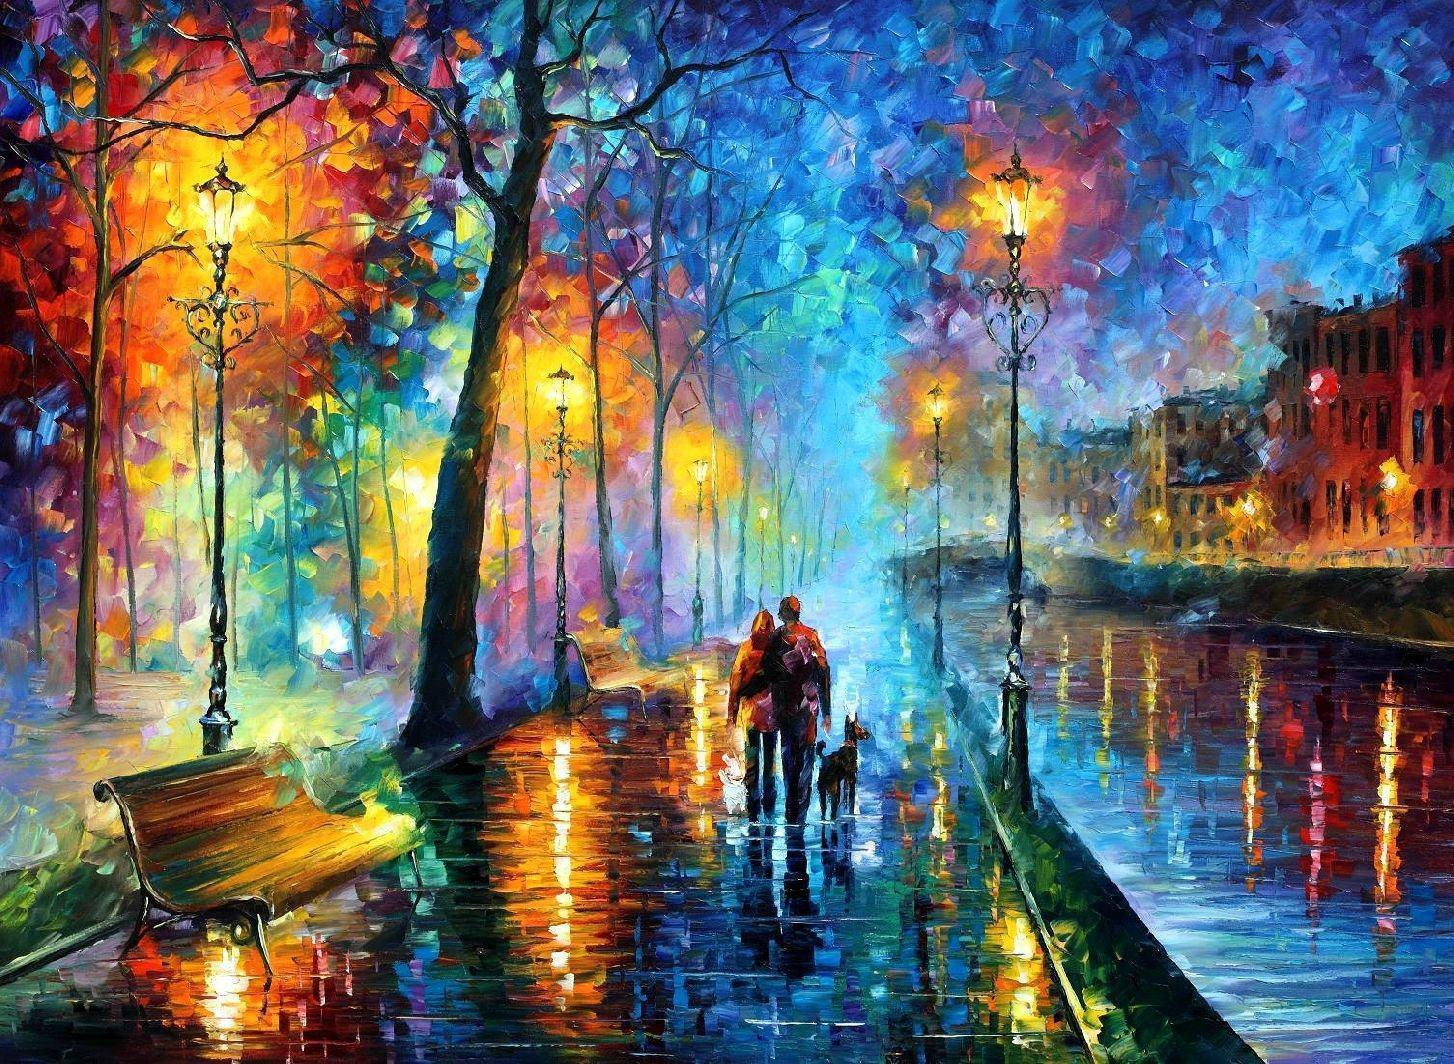

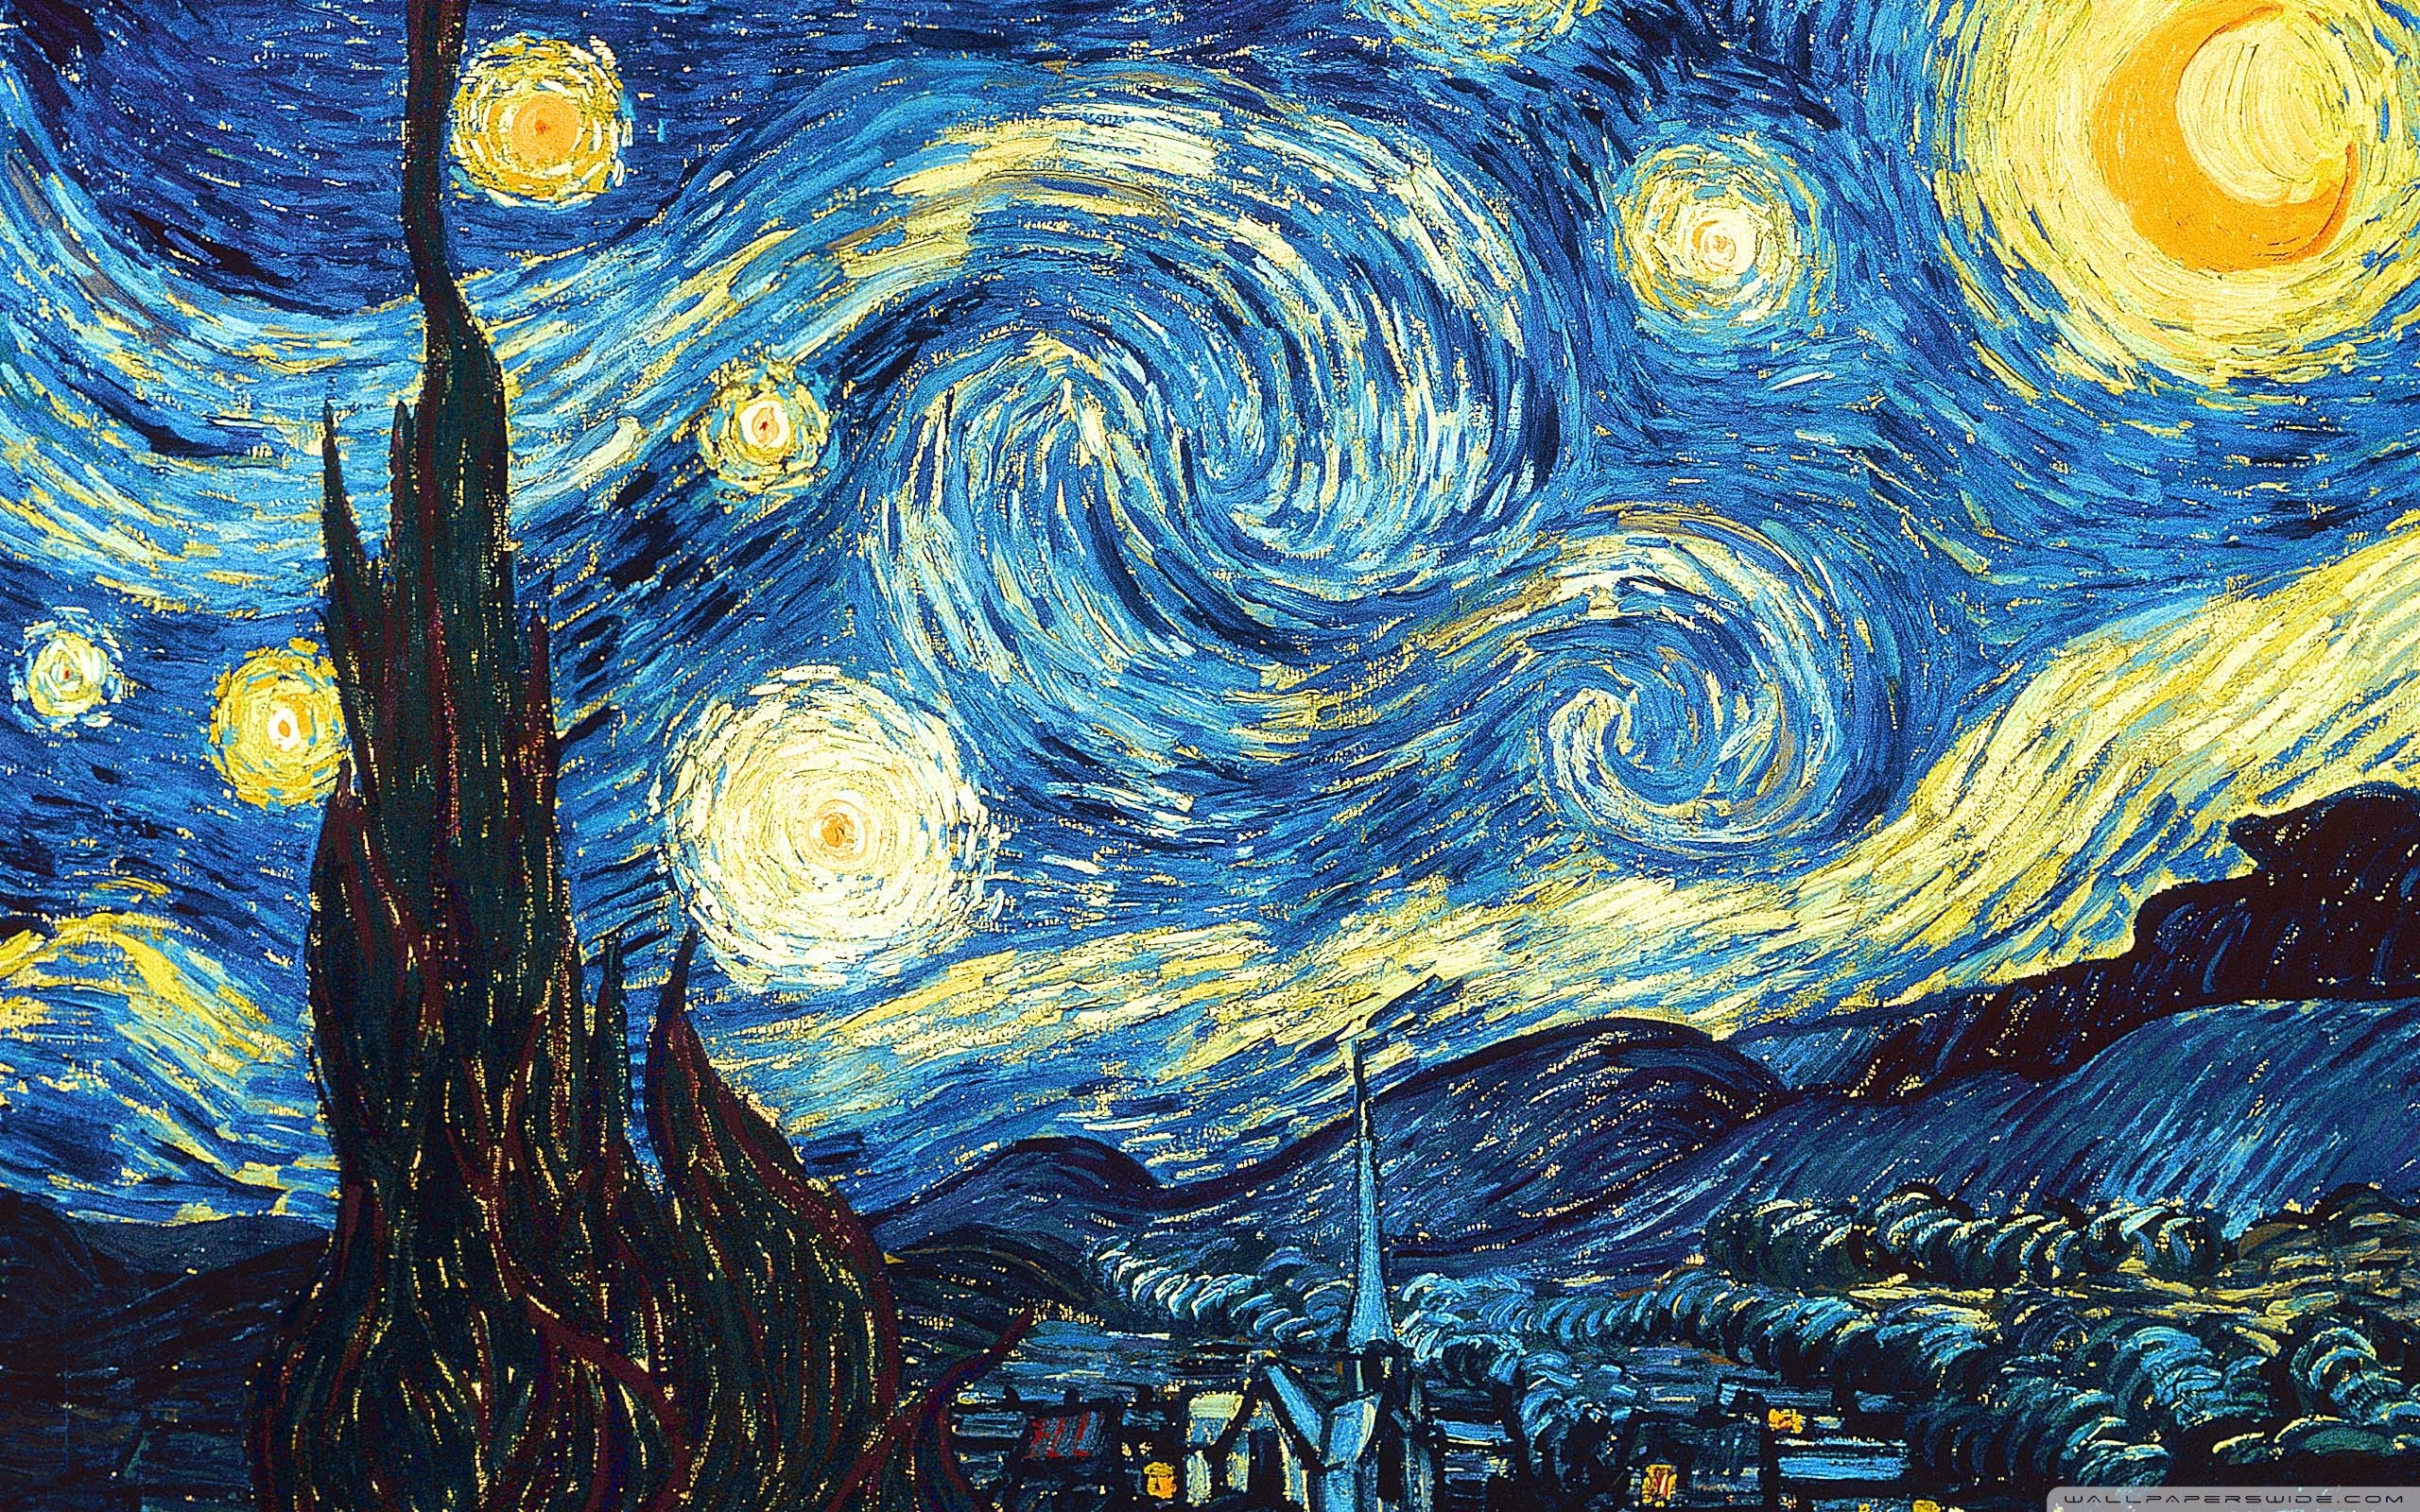

In [20]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [30]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [22]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [23]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 12s 0us/step


In [24]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [25]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [33]:
from tensorflow.keras.preprocessing.image import save_img
optimizer = SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        save_img(fname, img)

Iteration 100: loss=13117.92
Iteration 200: loss=11168.63
Iteration 300: loss=10371.79
Iteration 400: loss=9918.54
Iteration 500: loss=9619.45
Iteration 600: loss=9404.65
Iteration 700: loss=9240.74
Iteration 800: loss=9110.60
Iteration 900: loss=9004.12
Iteration 1000: loss=8915.75
Iteration 1100: loss=8840.64
Iteration 1200: loss=8776.14
Iteration 1300: loss=8720.10
Iteration 1400: loss=8671.03
Iteration 1500: loss=8627.68
Iteration 1600: loss=8589.04
Iteration 1700: loss=8554.60
Iteration 1800: loss=8523.65
Iteration 1900: loss=8495.73
Iteration 2000: loss=8470.33
Iteration 2100: loss=8447.19
Iteration 2200: loss=8425.92
Iteration 2300: loss=8406.38
Iteration 2400: loss=8388.46
Iteration 2500: loss=8371.83
Iteration 2600: loss=8356.42
Iteration 2700: loss=8342.10
Iteration 2800: loss=8328.77
Iteration 2900: loss=8316.38
Iteration 3000: loss=8304.84
Iteration 3100: loss=8294.10
Iteration 3200: loss=8283.99
Iteration 3300: loss=8274.58
Iteration 3400: loss=8265.74
Iteration 3500: loss

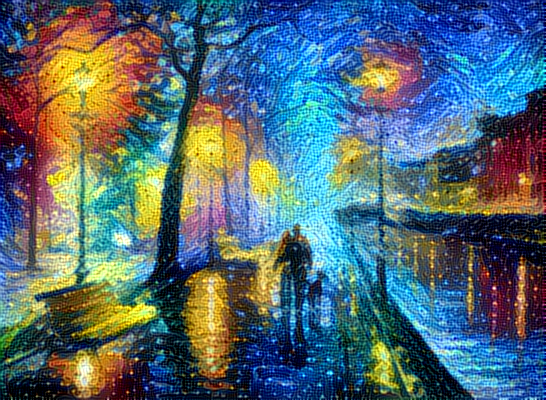

In [34]:
display(Image(result_prefix + "_at_iteration_4000.png"))

# 2. YOLO - Detecting Bananas in Your Hand

In this part of the lab, you will add YOLO to a video stream as given below using cv2 to detect bananas in a video stream.

To install OpenCV, type:

```shell
pip3 install opencv-python
```

## 2.1. Training YOLO To Detect Bananas

You will implement YOLO to detect bananas in images.

<img src='2.png'>

Resources for YOLO can be found in:

https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/

https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/

https://medium.com/@enriqueav/object-detection-with-yolo-implementations-and-how-to-use-them-5da928356035

https://github.com/experiencor/keras-yolo2

The directory bananas-detection contains two directories, bananas-train and bananas_train and bananas_val, and label.csv contains the name of the file and the enclosing box for banana in the image.

In [2]:
df = pd.read_csv('banana-detection/banana-detection/bananas_train/label.csv')
df

img_name  label  xmin  ymin  xmax  ymax
0      0.png      0   104    20   143    58
1      1.png      0    68   175   118   223
2      2.png      0   163   173   218   239
3      3.png      0    48   157    84   201
4      4.png      0    32    34    90    86
..       ...    ...   ...   ...   ...   ...
995  995.png      0   171   101   214   147
996  996.png      0    42    57    83    96
997  997.png      0    47    54    86   109
998  998.png      0    43   125    90   166
999  999.png      0   191    99   249   152

[1000 rows x 6 columns]

Explain in your words how Yolo works.  You should utilize ChatGPT or equivalent to help you write the summary.


## 2.2. Using CV2

In the second part of the lab, you will use OpenCV to detect the position of a banana on a video stream.

In [12]:
# train on colab the Yolo network on bigger machine
# save weights and any other configuration parameters

In [3]:
#Provided by https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [4]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [5]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

In [18]:
import struct
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.86620545387268
banana 85.63247323036194


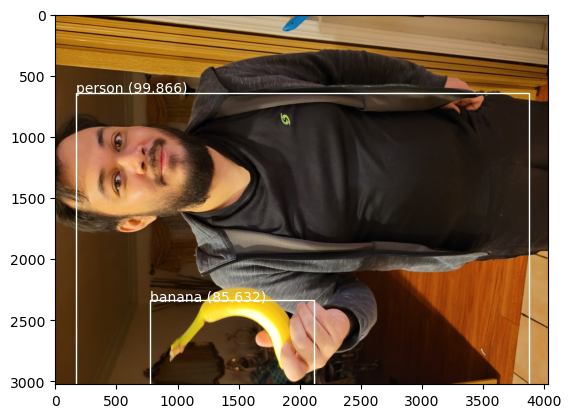

In [8]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = "banana_left.jpg"
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [9]:
def load_image_pixels_from_array(image_array, shape):
    # Assuming image_array is already in the correct color format (RGB)
    
    # Original dimensions
    height, width = image_array.shape[:2]
    
    # Resize the image with the required size
    image_resized = cv2.resize(image_array, shape)
    
    # Convert to numpy array (if not already) and scale pixel values to [0, 1]
    image = img_to_array(image_resized)
    image = image.astype('float32')
    image /= 255.0
    
    # Add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [10]:
def draw_boxes_on_frame(frame, v_boxes, v_labels, v_scores):
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # Draw the box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)
        cv2.rectangle(frame, (0, 0), (frame.shape[1]-1, frame.shape[0]-1), (0, 255, 0), 3)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        # Put the label text above the rectangle
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

In [12]:
import cv2
import numpy as np

vc = cv2.VideoCapture("banana_filter.mp4")
# vc = cv2.VideoCapture(0)

while True:
    ret, frame = vc.read()
    if not ret:
        print('Stopped video')
        break
    h, w, _ = frame.shape
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print("height:   ", h)
    print("width:    ", w)
    img = cv2.resize(img, (w, h))
    
    #img_to_deep_learning = img
    
    # Add your code here to add YOLO
    
    image, image_w, image_h = load_image_pixels_from_array(img, (input_w, input_h))
    # make prediction
    yhat = model.predict(image)
    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])
    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.6
    boxes = list()
    for i in range(len(yhat)):
    	# decode the output of the network
    	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    for i in range(len(v_boxes)):
    	print(v_labels[i], v_scores[i])
    # draw what we found
    draw_boxes_on_frame(frame, v_boxes, v_labels, v_scores)

    
    img_mean = np.array([127, 127, 127])
    img = (img - img_mean) / 128
    
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    
    cv2.imshow("Video", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print('Keyboard typed')
        break

vc.release()
cv2.destroyAllWindows()
print('... waiting for any key to be pressed')
cv2.waitKey(0)
print('... done')

height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.88215565681458
person 99.90734457969666
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.89021420478821
person 99.91597533226013
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.8841404914856
person 99.90143775939941
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.8687744140625
person 99.90396499633789
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.88699555397034
person 99.90720748901367
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.88988637924194
person 99.9208390712738
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
banana 99.90411400794983
person 99.90209341049194
height:    960
width:     540
[(1, 13, 13, 255), (1, 26, 2

As part of the submission results, you will submit a video of banana detection.

# 3. Word2Vec

Let's first download a word2vec dictionary with a vector dimension 300 for each word from Google News.

In [35]:
!pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 3.6 MB/s eta 0:00:07
    --------------------------------------- 0.4/24.0 MB 4.5 MB/s eta 0:00:06
    --------------------------------------- 0.4/24.0 MB 4.5 MB/s eta 0:00:06
   - -------------------------------------- 1.0/24.0 MB 5.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.2/24.0 MB 5.3 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/24.0 MB 5.8 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/24.0 MB 6.2 MB/s eta 0:00:04
   --- ------------------------------------ 2.3/24.0 MB 6.2 MB/s eta 0:00:04
   ---- ----------------------------------- 2.6/24.0 MB 6.2 MB/s eta 0:00:04
   ---- ----------------------------------- 2.8/24.0 MB 6.0 MB/s eta 0:00:04
   ----- ---------------------------------- 3.1/24.0 MB 5.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.3/24.0 MB 5.8 MB/s eta 0:00:04
   ---

In [36]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[=-------------------------------------------------] 2.8% 46.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================================--] 96.8% 1610.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [37]:
king = wv["king"]

king.shape

(300,)

Because each word is represented as a vector in the space $\cal{R}^{300}$, we can compute similarity between words.

In [38]:
print(wv.most_similar(positive=["king", "queen", 'royal'], topn=10))

[('monarch', 0.7630466222763062), ('prince', 0.7122636437416077), ('princess', 0.6952192783355713), ('royals', 0.6911097764968872), ('princes', 0.6675854325294495), ('kings', 0.6575640439987183), ('queens', 0.6341845989227295), ('crown_prince', 0.6330040693283081), ('Queen_Consort', 0.6233131885528564), ('NYC_anglophiles_aflutter', 0.6210921406745911)]


In this case, you can simply compute the cosine distance between two words.

In [39]:
print(wv.similarity("suv", "car" ))

0.6054363


And you can compute words that match vector operations such as $\tt{vec(king)} - \tt{vec(man)} + \tt{vec(woman)} = ?$

In [40]:
print(wv.most_similar(positive=["king", "queen"], negative=["man"]))

[('queens', 0.595018744468689), ('monarch', 0.5815045833587646), ('kings', 0.5612992644309998), ('royal', 0.5204525589942932), ('princess', 0.5191516876220703), ('princes', 0.5086391568183899), ('NYC_anglophiles_aflutter', 0.5057314038276672), ('Queen_Consort', 0.49256712198257446), ('Queen', 0.48225677013397217), ('royals', 0.4781743586063385)]


Because every word is represented by a vector, at the end a ML model will only be able to represent vectors or differences in vectors as represented by the embedding. If the training set contains bias, the representation of the vectors will be as good as the training set.

In [41]:
print(wv.most_similar(positive=["woman", "king"], negative=["man"]))

[('queen', 0.7118192911148071), ('monarch', 0.6189674735069275), ('princess', 0.5902431011199951), ('crown_prince', 0.549946129322052), ('prince', 0.5377321243286133), ('kings', 0.5236843824386597), ('Queen_Consort', 0.5235944390296936), ('queens', 0.5181134343147278), ('sultan', 0.5098593235015869), ('monarchy', 0.5087411403656006)]


Let's see what's happening here by visualizing these 4 points.

In [42]:
king = wv['king']
queen = wv['queen']
woman = wv['woman']
man = wv['man']

labels = ['king', 'queen', 'woman', 'man']
x = np.array([king, queen, woman, man])

results = umap.UMAP().fit_transform(x)

r = { label: results[i] for i, label in enumerate(labels) }
for label in r:
    print(label, r[label])

C:\Users\Owner\anaconda3\envs\tf-gpu\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


king [ 0.8872911 29.62858  ]
queen [ 0.15152405 29.00105   ]
woman [-0.46538  29.999722]
man [ 0.17829739 30.54502   ]


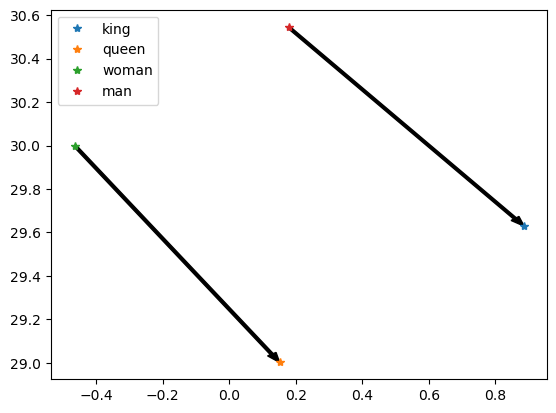

In [43]:
for label in r:
    plt.plot(r[label][0], r[label][1], '*', label=label)
plt.arrow(
    r['man'][0], r['man'][1], 
    r['king'][0]-r['man'][0], r['king'][1]-r['man'][1],
    color='black', length_includes_head=True, width=0.01)
plt.arrow(
    r['woman'][0], r['woman'][1], 
    r['queen'][0]-r['woman'][0], r['queen'][1]-r['woman'][1],
    color='black', length_includes_head=True, width=0.01)
plt.legend()
plt.show()

Why is it important to remove bias from the embeddings?

Imagine in a situation where you are analyzing if you are going to give loan to a person based on the difference of two embeddings $\sum (v_1 - v_2)$, and suppose that the same difference appears in $\sum (v_3 - v_4)$.

For example, $v_1$ could be derived a sentence implying the person has good credit, and $v_2$ could be derived from a sentece where the person has no outstanding loans, whereas $v_3$ could represent a person's race, and $v_4$ could be derived from the person not paying the loan.

In our system, we will give a score based on the following result $v_1 - v_2 + v_3$ (very simple logistic classifier). The answer to the system could be a score that represents _the person will pay the loan_ or _the person will not pay the loan_. What will happen in this case?

# 4. Using Embeddings in Gradient Boosting

In this lab, you will use categorical embeddings to improve gradient boosting techniques (they are quite popular to win Kaggle competitions).

Suppose you have a table where one of the fields is day of the week (Monday = 0, Tuesday = 1, etc).

Several techniques exist to encode these variables, one-hot, using the average of the output label, etc.

Idea in this case is to use an auxiliary model with embeddings for the categorical variables, use the model to predict the output variable, and then transfer the values of the embeddings to the a new table, where you will run a gradient boosting algorithm. 

Part of this lab can be found in the following page.

https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0

In [45]:
df = pd.read_csv("bike_sharing_daily.csv")
df

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1  2011-01-01       1   0     1        0        6           0   
1          2  2011-01-02       1   0     1        0        0           0   
2          3  2011-01-03       1   0     1        0        1           1   
3          4  2011-01-04       1   0     1        0        2           1   
4          5  2011-01-05       1   0     1        0        3           1   
..       ...         ...     ...  ..   ...      ...      ...         ...   
726      727  2012-12-27       1   1    12        0        4           1   
727      728  2012-12-28       1   1    12        0        5           1   
728      729  2012-12-29       1   1    12        0        6           0   
729      730  2012-12-30       1   1    12        0        0           0   
730      731  2012-12-31       1   1    12        0        1           1   

     weathersit      temp     atemp       hum  windspeed  casual  registered  \
0             2  0.344167  0.363625  0.805833   0.160446     331         654   
1             2  0.363478  0.353739  0.696087   0.248539     131         670   
2             1  0.196364  0.189405  0.437273   0.248309     120        1229   
3             1  0.200000  0.212122  0.590435   0.160296     108        1454   
4             1  0.226957  0.229270  0.436957   0.186900      82        1518   
..          ...       ...       ...       ...        ...     ...         ...   
726           2  0.254167  0.226642  0.652917   0.350133     247        1867   
727           2  0.253333  0.255046  0.590000   0.155471     644        2451   
728           2  0.253333  0.242400  0.752917   0.124383     159        1182   
729           1  0.255833  0.231700  0.483333   0.350754     364        1432   
730           2  0.215833  0.223487  0.577500   0.154846     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
726  2114  
727  3095  
728  1341  
729  1796  
730  2729  

[731 rows x 16 columns]

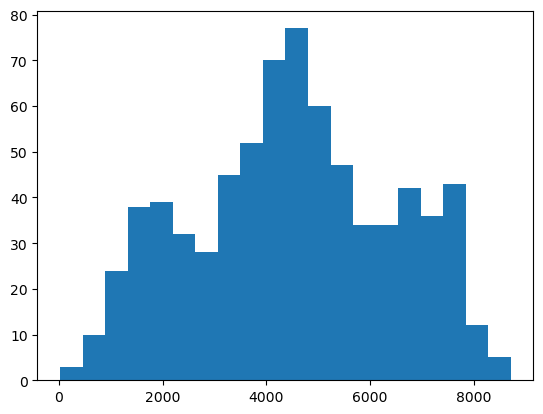

In [46]:
plt.hist(df.cnt.values, bins=20)
plt.show()

You will answer the following questions. This is related to the paper Cat2Vec (found at https://openreview.net/forum?id=HyNxRZ9xg).

### 4.1. In this table, which variables are categorical?

**season,yr,mnth,holiday,weekday,workingday,weathersit**

### 4.2. How many embeddings do you need to create?

**4+2+12+2+7+2+3 = 32**
**But according to the summary of the model below, we have 26 embeddings**

### 4.3. What are the embeddings size? 

Jeremy Howard suggested that the size of hte embedding vector should be $\tt{embedding\_size} = \min(50, (m+1) / 2)$, where $m$ is the number of categories.

**m = 32, 33/2 = Rounded Up 17 size.**

**Using the 26 embeddings, we have 27/2 = rounded up 14 size**

### 4.4. Train embeddings model

Train a small model with a number of embeddings, concatenated, and one dense layer, trying to predict the variable `cnt`.

```python
xl = []
for i in range(number_of_categorical_variables):
    x = Embedding(...)(input[i]) # (NI, NO)
    xl.append(x)
x = Concatente()(xl)
x = Dense(1)(x)
```

### 4.5. What are the sizes of the embedding matrices?

**32*17x7**


### 4.6. Create a new table with the values and embedded values

### 4.7. What's Gradient Boosting?

Gradient boosting comes with a weak learner to make predictions, a loss function that needs to be optimized, and an additive model to add those weak learners to minimize the loss function. These weak learners typically come in the form as decision trees. With an additive model, the trees are added one at a time, with the already existing trees remaining unchanged. Gradient boosting is considered a greedy algorithm that can overfirt a training dataset quickly.

### 4.8. Use Gradient Boosting (xgboost or catboost) to train the model with the new table

In [72]:
# add variables you will choose to create embeddings for
df_emb_vars = [
    'season',
    'yr',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit'
]

In [73]:
x = xi = Input((len(df_emb_vars),))
xl = []
for i in range(len(df_emb_vars)):
    v_min = df[df_emb_vars[i]].min()
    v_max = df[df_emb_vars[i]].max()
    n_values = v_max + 1
    output_dim = min(50, (n_values+1) // 2) + 1
    x = Embedding(
        n_values,
        output_dim, 
        input_length=1,
        name=df_emb_vars[i]
    )(xi[..., i]) # (NI, NO)
    xl.append(x)
x = Concatenate()(xl)
x = Dense(1)(x)

m = tf.keras.models.Model(xi, x)
m.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001))

In [74]:
m.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None,)              0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None,)              0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None,)              0           input_4[0][0]                    
____________________________________________________________________________________________

In [51]:
x = df[df_emb_vars].values
y = df.cnt.values

train_size = int(0.9 * len(x))

# split train and test sets
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

# Verifying the split
print(f"Training set size: {x_train.shape[0]}, Test set size: {x_test.shape[0]}")

Training set size: 657, Test set size: 74


In [52]:
# scale train an test data
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
y_train_s = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

# Apply the same transformation to the test data
y_test_s = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [53]:
# train model
from tensorflow.keras.callbacks import EarlyStopping
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = m.fit(
    x_train, y_train_s, # Training data
    epochs=100,         # Number of epochs to train for (adjust as necessary)
    batch_size=32,      # Batch size (adjust based on your data size and computational resources)
    validation_data=(x_test, y_test_s), # Validation data to monitor performance
    callbacks=[early_stopping] # Early stopping callback
)

Epoch 1/100
21/21 [==============================] - 0s 7ms/step - loss: 0.8124 - val_loss: 0.8234
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7804 - val_loss: 0.8409
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7526 - val_loss: 0.8632
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7269 - val_loss: 0.8832
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7045 - val_loss: 0.9057
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6862 - val_loss: 0.9253
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6715 - val_loss: 0.9464
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6598 - val_loss: 0.9586
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6512 - val_loss: 0.9654
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6447 - val_loss: 0.9724
Epoch 11/

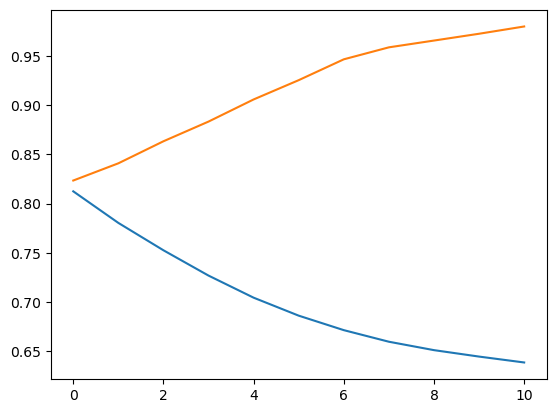

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')

In [55]:
# let's analyze one of the layers so see the correlations between
# the categorical values

layer = m.get_layer('mnth')
weights = layer.get_weights()[0]
for i in range(1, weights.shape[0]):
  u = weights[i]
  u = u / np.linalg.norm(u)
  print(i)
  for j in range(1, weights.shape[0]):
    v = weights[j]
    v = v / np.linalg.norm(v)
    print('    ', j, np.dot(u, v))

1
     1 1.0
     2 -0.26994705
     3 0.46329412
     4 0.28541347
     5 -0.3524353
     6 0.16826817
     7 0.076724455
     8 0.019841313
     9 0.18253341
     10 -0.013242334
     11 0.48183006
     12 -0.15910691
2
     1 -0.26994705
     2 1.0
     3 -0.034010842
     4 -0.25412223
     5 -0.2924415
     6 -0.5289133
     7 -0.49924508
     8 0.47182631
     9 -0.70287824
     10 0.09047164
     11 -0.028722063
     12 0.085017085
3
     1 0.46329412
     2 -0.034010842
     3 1.0
     4 0.75095165
     5 -0.47662997
     6 -0.1559222
     7 -0.22687638
     8 0.12690513
     9 -0.084080264
     10 -0.33684534
     11 0.27066654
     12 0.29437077
4
     1 0.28541347
     2 -0.25412223
     3 0.75095165
     4 1.0000001
     5 -0.45809752
     6 -0.20182973
     7 -0.32794613
     8 0.14622988
     9 0.255103
     10 -0.47565815
     11 0.41927734
     12 0.16490062
5
     1 -0.3524353
     2 -0.2924415
     3 -0.47662997
     4 -0.45809752
     5 1.0000001
     6 0.5574212
   

In [56]:
# let's create a new dataframe with the embedding values
x_new = df[['temp', 'hum', 'windspeed']].values
for i in range(len(df_emb_vars)):
    values = df[df_emb_vars[i]].values
    layer = m.get_layer(df_emb_vars[i])
    weights = layer.get_weights()[0]
    emb_values = weights[values]
    x_new = np.concatenate([x_new, emb_values], axis=-1)

In [57]:
x_new.shape

(731, 13)

In [58]:
train_size = int(0.9 * len(x_new))

x_train = x_new[:train_size]
y_train = y[:train_size]
x_test = x_new[train_size:]
y_test = y[train_size:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((657, 13), (657,), (74, 13), (74,))

In [67]:
import xgboost as xgb
from xgboost import XGBRegressor

# # Prepare DMatrix for XGBoost
# dtrain = xgb.DMatrix(x_train, label=y_train)
# dtest = xgb.DMatrix(x_test, label=y_test)

# # Define parameters for the XGBoost model
# params = {
#     'max_depth': 6,  # Maximum depth of a tree
#     'eta': 0.3,      # Learning rate
#     'objective': 'reg:squarederror',  # Objective function
#     'eval_metric': 'rmse',            # Evaluation metric for validation data
# }

# # Number of boosting rounds
# num_round = 100

# # Instead of training here, we're preparing the model setup.
# # The training step will be explicitly called on 'gb_model' later.
# gb_model_setup = {
#     "params": params,
#     "dtrain": dtrain,
#     "num_boost_round": num_round,
#     "evals": [(dtest, "test")],
#     "early_stopping_rounds": 10
# }

In [68]:
import xgboost as xgb
from xgboost import XGBRegressor
# create your model here
gb_model = XGBRegressor(max_depth=6, learning_rate=0.3, n_estimators=100, objective='reg:squarederror', eval_metric='rmse')

In [69]:
gb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [70]:
p_test = gb_model.predict(x_test)

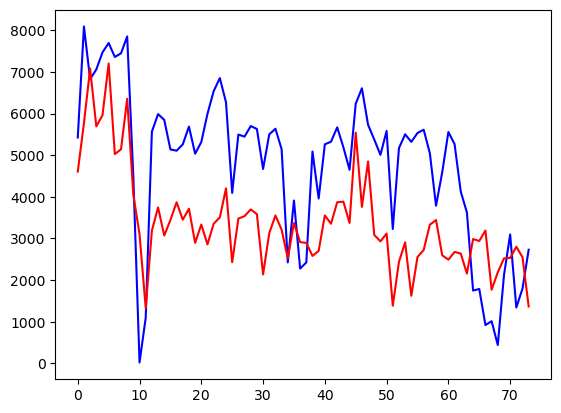

In [71]:
plt.plot(y_test, color='blue')
plt.plot(p_test, color='red')
plt.show()

Which model performed best? the GB model or the DL model?

DL model is better